$\newcommand{\xv}{\mathbf{x}}
\newcommand{\Xv}{\mathbf{X}}
\newcommand{\yv}{\mathbf{y}}
\newcommand{\zv}{\mathbf{z}}
\newcommand{\av}{\mathbf{a}}
\newcommand{\Wv}{\mathbf{W}}
\newcommand{\wv}{\mathbf{w}}
\newcommand{\tv}{\mathbf{t}}
\newcommand{\Tv}{\mathbf{T}}
\newcommand{\muv}{\boldsymbol{\mu}}
\newcommand{\sigmav}{\boldsymbol{\sigma}}
\newcommand{\phiv}{\boldsymbol{\phi}}
\newcommand{\Phiv}{\boldsymbol{\Phi}}
\newcommand{\Sigmav}{\boldsymbol{\Sigma}}
\newcommand{\Lambdav}{\boldsymbol{\Lambda}}
\newcommand{\half}{\frac{1}{2}}
\newcommand{\argmax}[1]{\underset{#1}{\operatorname{argmax}}}
\newcommand{\argmin}[1]{\underset{#1}{\operatorname{argmin}}}$

# Reinforcement Learning vs Randomly Moving Game Assets

<i>by Isaac Law, May 12, 2019<i>

## Introduction

For this project I am going to create a program that uses reinforcement learning to play a simple video game. I developed a game in which a sheep dog tries to push the sheep into their pen. The challenge of the game is that the sheep move randomly.  The reinforcement model will not be able to play the game by learning a single optimum path. It will have to learn to use the herding dynamic between the sheep dog and the sheep. To successfully play the game the model will need to learn how to position the player behind the sheep and chase them towards the pen. The model will also need to learn how to handle map elements such as corners and walls.  Corners are a special case because sheep can be stuck in them if not handled correctly.

The model is trained with typical reinforcement learning practices.  Each game state is scored as +50 for each sheep in the pen, and -.001 per meter each sheep is from the pen. At first completely random actions are taken by the agent (sheep dog).  The score of these random actions are used to train the neural network. Over time the neural network learns which actions at each state lead to the optimal result.

The results were found to be successful. The reinforcement learning model can be trained to a point where it is able to finish every game.  There are times when games take a longer amount of time, likely due to the sheep escaping into a corner, but even these are completed in a reasonable amount of time.

## Methods

There were two major stages of development.  The first milestone was to develop the game that would be used to train the neural network on. Once the game was finished I moved on to learning how to implement a reinforcement learning algorithm in Tensor Flow.

### Game Development
#### Resources I used:  
* [Pygame Documentaion](https://www.pygame.org/)  
* [Pygame Tutorial: Getting Started : Nerd Paradise](https://nerdparadise.com/programming/pygame/part1/)

The goal when I was making the game was that the sheep moved in semi-realistic ways. They should randomly wander most of the time, but when the sheep dog approaches they should run in the opposite direction. They should also prefer to stay in a group.   
Another priority was that the game should be playable by a human.  The first step of debugging the neural network was to be sure the game was playable.  This made it easy to tune the herding dynamic, and to test various map settings during training.  
Graphics and keyboard input are not necessary to run the game. All of the functionality is accessible through a number of Python endpoints. The ```GameMap``` class in ```game_assets.py``` has functions to get/set state, make moves, and check whether the game is finished.

As long as the PyGame library is installed "Sheep Dog Simulator" can be played with  ```python run_game.py```.
Game settings are found at the top of ```game_assets.py```, the map file is specified at the beginning of ```run_game.py```.

![title](img/sd_simulator.png)This game instance is being played with eight sheep.  They are free to roam around the lighter green grass. The game will be over once they are all pushed into the yellow pen.
![title](img/sd_simulator2.png)
![title](img/sd_simulator3.png)
The reinforcement learning model will be trained on a simpler map than the one pictured. The map used for training has one sheep, and no walls. Because complex maps require much longer training, it seems sufficient to demonstrate the training algorithm working at a smaller scale. With minor tweaks the reinforcement learning algorithm should be able to learn to play any map. 

### Creating the Reinforcement Learning Algorithm
#### Resources I used:  
* [TensorFlow Documentation](www.tensorflow.org)  
* [TensorFlow, the Confusing Parts](https://jacobbuckman.com/post/tensorflow-the-confusing-parts-1/)
* [Simple Reinforcement Learning with TensorFlow](https://medium.com/emergent-future/simple-reinforcement-learning-with-tensorflow-part-0-q-learning-with-tables-and-neural-networks)
* Lecture 23: Reinforcement Learning with Neural Network as Q Function

The method I use to train the neural network is Q learning. Q learning can be used to train models to play games, without knowing the rules. Instead of knowing the rules the models receive a score for each move they make in a game. An optimal Q-function is a policy that results in the perfect decision at every decision point. If a video game agent is looking at three different options, it can input each option into the Q-function and receive a score for each.  The option with the highest score is the one the agent should take. 'Q' can be thought of as the quality of a state based off of the estimated score.

Q learning is typically used in situations where the true optimal Q-function is unknown. The goal of Q learning is to use available information to train a neural network to mimic the actual Q-function.  

#### How Q-Learning learns the sheep dog simulator game
<i>In the following paragraph 'state' refers to the current positions of the sheep dog and the sheep, 'state space' refers to the minimum and maximum positions they can travel to</i>

Before training begins the neural network has no concept of the rules for sheep - dog interactions, map boundaries, pen position, or how to win the game.  By the end of training, the network is able to repeatedly choose the correct action (left, right, up, or down). By choosing the correct action at each game state the network is able successfully chase the sheep into the pen and win the game.

### Imports and setting up variables

In [1]:
import tensorflow as tf
import tensorflow.contrib.slim as slim
import numpy as np
import random
from IPython.display import display, clear_output
import time

In [2]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

In [3]:
from game_assets import GameMap
game_map = GameMap('map_rl.txt', ms=4)
NUM_SHEEP = len(game_map.sheep)
NUM_ACTIONS = 4
# Two inputs for each player and sheep postion, 4 for one hot action representation
SA_LEN = 2 + 2 * NUM_SHEEP + NUM_ACTIONS

pygame 1.9.5
Hello from the pygame community. https://www.pygame.org/contribute.html


### Define the Tensorflow Graph
The placeholders accept game state as input. This input is fed into a [20,20,20,20] neural network. The network is trained with the Adam optimizer algorithm using the loss of the correct Q value - the estimated Q value.

In [45]:
def create_graph():
    # Create the nodes as global variables, so that they are accessible in every function
    global input_state, goal_q, q_est, train_op, loss
    tf.reset_default_graph()
    input_state = tf.placeholder(shape=[None, SA_LEN], dtype=tf.float32)
    goal_q = tf.placeholder(shape=[None, 1], dtype=tf.float32)

    hidden_one = slim.fully_connected(input_state, 20, activation_fn=tf.nn.tanh)
    hidden_two = slim.fully_connected(hidden_one, 20, activation_fn=tf.nn.tanh)
    hidden_three = slim.fully_connected(hidden_two, 20, activation_fn=tf.nn.tanh)
    hidden_four = slim.fully_connected(hidden_three, 20, activation_fn=tf.nn.tanh)

    q_est = slim.fully_connected(hidden_four, 1, activation_fn=None)
    loss = (q_est - goal_q)**2
    optimizer = tf.train.AdamOptimizer(1e-3)
    train_op = optimizer.minimize(loss )

### Choosing the proper action
With an epsilon value of 1.0 ```action_picker``` always returns a random action. With an epsilon of 0 the neural network decides every action. Intermediate epsilon are used to randomly choose between the two.  Typically training starts with high epsilon values to encourage lots of random exploring. As the neural network improves, the epsilon value is lowered.

In [ ]:
def action_picker(sess, state, epsilon):
    actions = [i for i in range(1, 1+NUM_ACTIONS)]
    
    if np.random.uniform() < epsilon:
        action = np.random.choice(actions)
    else:
        state_actions = []
        random_actions = actions[:]
        np.random.shuffle(random_actions)
        for a in random_actions:
            state_actions.append(state_append_action(state, a))
        state_actions = np.array(state_actions).reshape(NUM_ACTIONS, SA_LEN)
        Qs = sess.run([q_est], feed_dict={input_state: state_actions})
        ai = np.argmax(Qs)
        action = random_actions[ai]

    Q = sess.run([q_est], feed_dict={input_state: state_append_action(state, action)})
    Q = Q[0]
    return action, Q

### Helper functions
These properly format state and give each state a score

In [5]:
def state_append_action(state, action=1):
    '''
    state: [1+num_sheep, 2]
    action: range(1, 6)
    '''
    oh_action = one_hot_action(action)
    state_c = np.array(state)
    state_c = state_c.reshape(1, -1)
    # Normalize position data to 0-1 range
    state_c = state_c / game_map.map_size[0]
    state_c = np.concatenate((state_c, oh_action), axis=1)
    return state_c

def one_hot_action(action):
    '''
    Converts action (int) into one hot array
    '''
    action = int(action)
    if action < 1 or action > NUM_ACTIONS:
        print("OUT OF BOUNDS: " + str(action))
        action = 1
    oh = []
    for i in range(0, NUM_ACTIONS):
        val = 1 if action == i+1 else 0
        oh.append(val)
    return np.array(oh).reshape(1, -1)
        
def reinforcement(state):
    '''
    The score is:
       # sheep in pen * 10
    - dis(sheep, pen)
    '''
    saved_state, _ = game_map.get_state()
    game_map.set_state(state)
    score = game_map.get_score(in_pen_score=50, dis_from_pen_penalty=.001)
    game_map.set_state(saved_state)
    return score

### Collect game state samples
```sample_game``` makes ```num_samples``` worth of moves from the starting state. The state, reinforcement, and estimated Q value are returned to be used for training.

In [6]:
def sample_game(sess, cur_state, num_samples, epsilon):
    '''
    Retrieves a num_samples of move and reward information
    cur_state: [1+num_sheep, 2]
    '''
    X = np.zeros((num_samples, SA_LEN))
    R = np.zeros((num_samples, 1))
    Qn = np.zeros((num_samples, 1))
    
    game_map.set_state(cur_state)
    action, _ = action_picker(sess, cur_state, epsilon)
    
    for step in range(num_samples):
        game_map.advance_moves(action, 5)
        next_state, is_fin = game_map.get_state()
        if is_fin:
            X = X[0:step, :]
            R = R[0:step, :]
            Qn = Qn[0:step, :]
            break
        ref_next = reinforcement(next_state)
        action_next, q_next = action_picker(sess, next_state, epsilon)
        
        cur_state = state_append_action(cur_state, action)
        X[step, :] = cur_state
        R[step, 0] = ref_next
        Qn[step, 0] = q_next
        cur_state, action = next_state, action_next
        
    return X, R, Qn

### Training
The number of ```simulated_games``` are played to train the network.  Each game is ran until either the game is successfully won, or ```number_updates * samples``` worth of moves have been played.  As the games progress the epsilon value is decayed so that moves are more often chosen by the neural network.

```goal_qs = R + gamma*Qn``` defines the typical reinforcement learning update step.  The score of the current state ```R``` is added together with the expected Q value ```Qn``` for the following state.  This trains the neural network to associate the current state with being able to obtain the rewards of the neighboring state.

In [ ]:
def run_training(save_file_name):
    create_graph()
    saver = tf.train.Saver(max_to_keep=None)
    gamma = .8
    number_updates = 8
    simulated_games = 10000
    samples = 250
    epsilon = 1
    epsilon_decay = .99993
    
    game_results = []
    epsilon_trace = []
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        try:
            for game_num in range(simulated_games):
                game_map.load_map()
                player_pos = []
                sheep_pos = []

                for un in range(number_updates):
                    state, is_fin = game_map.get_state()

                    if is_fin:
                        print("%s finished epsilon is %s" % (game_num, epsilon))
                        break
                    X, R, Qn = sample_game(sess, state, samples, epsilon)
                    # Train the model with the returned samples
                    goal_qs = R + gamma*Qn
                    _loss, _ = sess.run([loss, train_op], feed_dict={input_state: X, goal_q: goal_qs})
                    player_pos.extend(X[:, :2])
                    sheep_pos.extend(X[:, 2:2+2*NUM_SHEEP])
                    epsilon = epsilon_decay * epsilon

                if game_num % 1000 == 0 and game_num > 0:
                    epsilon_trace.append(epsilon)
                    number = game_num // 1000
                    saver.save(sess, save_file_name + "_" + str(number))
    
                game_results.append(len(player_pos))
        except KeyboardInterrupt:
            pass
    player_pos = np.array(player_pos)
    sheep_pos = np.array(sheep_pos)
    return game_results, player_pos, sheep_pos, epsilon_trace

### Running the model
Training saves the models to multiple checkpoint files.  These can be used to reload the neural network at these checkpoints, and simulate games with the neural network.

Notice how ```epsilon=0``` in the call to ```action_picker```.  The neural network is deciding every move of the game.

In [42]:
def use_model(load_file_name, number_games, max_moves):
    create_graph()
    saver = tf.train.Saver()
    game_results = []
    player_pos = []
    sheep_pos = []
    player_ps = []
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        saver.restore(sess, load_file_name + '.ckpt')
        try:
            for game_num in range(number_games):
                game_map.load_map()
                player_pos = []
                sheep_pos = []

                number_moves = max_moves
                for move_num in range(max_moves):
                    state, is_fin = game_map.get_state()
                    if is_fin:
                        number_moves = move_num + 1
                        break
                    next_action, _ = action_picker(sess, state, epsilon=0)
                    cur_state = state_append_action(state, next_action)
                    player_pos.extend(cur_state[0:2]) 
                    sheep_pos.extend(cur_state[1:1+NUM_SHEEP,:])
                    game_map.advance_moves(next_action, 5)
                #print("%s: %s" % (game_num, number_moves))
                game_results.append(number_moves)
                player_ps.append(player_pos)
        except KeyboardInterrupt:
            pass
    player_pos = np.array(player_pos).reshape(-1, 2)
    sheep_pos = np.array(sheep_pos).reshape(-1, 2*NUM_SHEEP)
    return game_results, player_pos, sheep_pos, player_ps

### Running the model
Use ```train``` to choose between training the model, or simulating games with models previously saved to disk.  If no checkpoints exist in the ```tf_models``` folder, training has to be run first.

In [48]:
train = False
if train:
    game_results, player_pos, sheep_pos, epsilon_trace = run_training('tf_models/model')
else:
    game_results = []
    for i in range(1, 10):
        model_name = 'tf_models/model_' + str(i)
        temp_results, player_pos, sheep_pos, player_ps = use_model(model_name, number_games=20, max_moves=1000)
        game_results.extend(temp_results)

INFO:tensorflow:Restoring parameters from tf_models/model_1
INFO:tensorflow:Restoring parameters from tf_models/model_2
INFO:tensorflow:Restoring parameters from tf_models/model_3
INFO:tensorflow:Restoring parameters from tf_models/model_4
INFO:tensorflow:Restoring parameters from tf_models/model_5
INFO:tensorflow:Restoring parameters from tf_models/model_6
INFO:tensorflow:Restoring parameters from tf_models/model_7
INFO:tensorflow:Restoring parameters from tf_models/model_8
INFO:tensorflow:Restoring parameters from tf_models/model_9


IndexError: index 0 is out of bounds for axis 0 with size 0

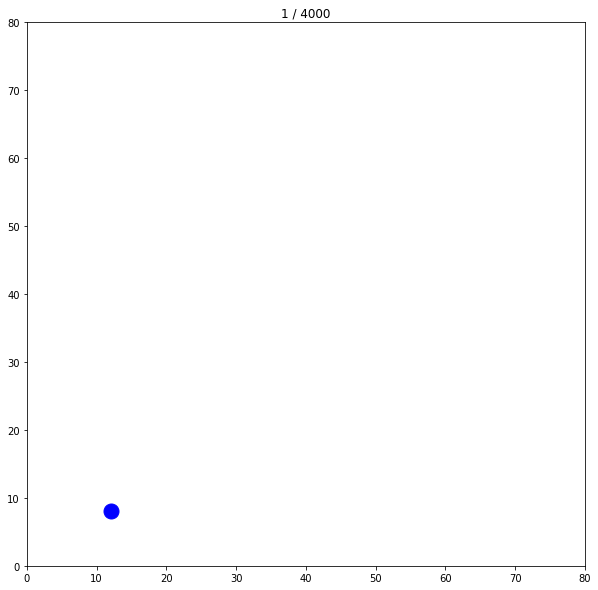

In [18]:
def goal_rectangles():
    rects = []
    for x, y, xlen, ylen in game_map.pen_rects:
        rect = patches.Rectangle((x,y), xlen, ylen,linewidth=1,edgecolor='r')
        rects.append(rect)
    return rects
    
def animate_game(player_pos, sheep_pos, samples_per_second=1, fade_back=None, start_frame=0):
    fig = plt.figure(figsize=(10, 10))
    ACTUAL_PER_SEC = 10
    samples_per_frame = samples_per_second // ACTUAL_PER_SEC
    if fade_back is not None:
        fade_back = fade_back * samples_per_frame
        
    map_x, map_y = game_map.map_size
    # Multiply by map_x to unnormalize from 0-1 range to actual position on map
    play_x = player_pos[:, 0] * map_x
    play_y = player_pos[:, 1] * map_x
    shp_x = sheep_pos[:, 0::2] * map_x
    shp_y = sheep_pos[:, 1::2] * map_x
    goal_rects = goal_rectangles()
    ax = plt.gca()
    for gr in goal_rects:
        ax.add_patch(gr)

    for i in range(start_frame, len(play_x), samples_per_frame):
        fig.clf()
        plt.ylim(0, map_x)
        plt.xlim(0, map_y)
        plt.title("%s / %s" % (i+1, len(play_x)))
        
        
        if fade_back is not None:
            for j in range(i-1, i-fade_back, -samples_per_frame):
                if j < 0:
                    break
                alph = .75 * (fade_back - i + j) / fade_back
                ms = (fade_back - i + j) * (15 / fade_back)
                plt.plot(play_x[j], play_y[j], marker='o', markersize=ms, color=(0,0,1), alpha=alph)
                plt.plot(shp_x[j], shp_y[j], marker='o', markersize=ms, linestyle='None', color=(0,1,0), alpha=alph)
        
        plt.plot(play_x[i], play_y[i], marker='o', markersize=15, color=(0,0,1))
        plt.plot(shp_x[i], shp_y[i], marker='o', markersize=15, linestyle='None', color=(0,1,0))
        clear_output(wait=True)
        display(fig)
        time.sleep(1/(ACTUAL_PER_SEC % samples_per_second + 1))
        
    clear_output(wait=True)

animate_game(player_pos, sheep_pos, 10, 5, start_frame=0)

## Results

In [69]:
def graph_game_results(gm_results, average=False, num_batches=0, avg_batch_size=0):
    games_per_model = avg_batch_size
    averaged_results = []
    for i in range(num_batches):
        average = 0
        for j in range(games_per_model):
            average += game_results[i*games_per_model+j]
        average = average / games_per_model
        averaged_results.append(average)
        
    fig = plt.figure(figsize=(16,16))
    if average:
        plt.plot(averaged_results)
        plt.title("Average Number of Moves to Finish the Game")
        plt.xlabel("Number of Trained Games in Neural Network")
        plt.xticks(ticks=[i for i in range(num_batches)], labels=[(i+1)*1000 for i in range(num_batches)])
    else:
        plt.plot(gm_results)
        plt.title("Number of Moves to Finish the Game")
        plt.xlabel("Game Number")
    plt.ylabel("Number of Moves to Finish Game")
    plt.show()

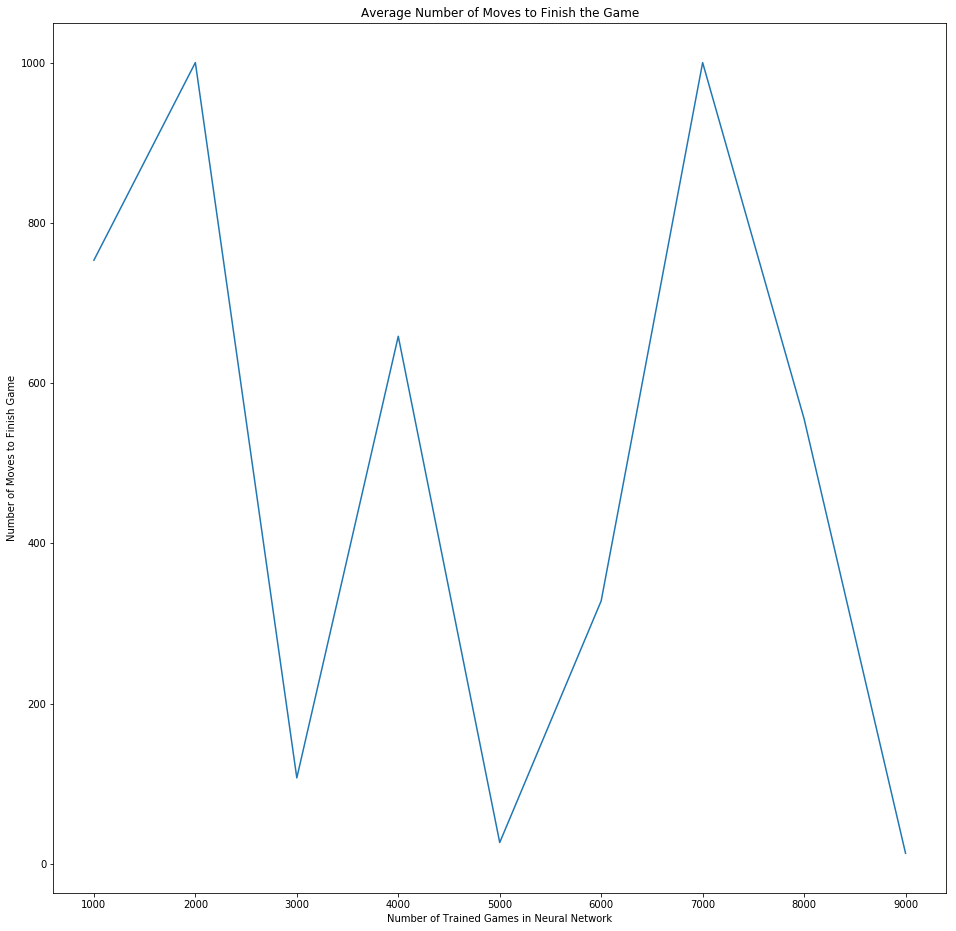

In [70]:
graph_game_results(game_results, True, 9, 20)

It appears from the chart that the network keeps going through cycles of forgetting the right moves for winning the game.  The two spikes to 1000 are where the network lost the ability to finish the game. 1000 was the maximum number of moves allowed. This likely happened because it overfit on one behavior, and forgot how to use a different behavior in other situations.  Possible improvements might be observed if the learning rate and epsilon were lowered to slow training.

From the chart it would appear that either the model at 5000 games, or 9000 games should be selected for continued use.

In [ ]:
model_name = 'tf_models/model_' + str(5)
gm_results, _, _, _ = use_model(model_name, number_games=100, max_moves=1000)

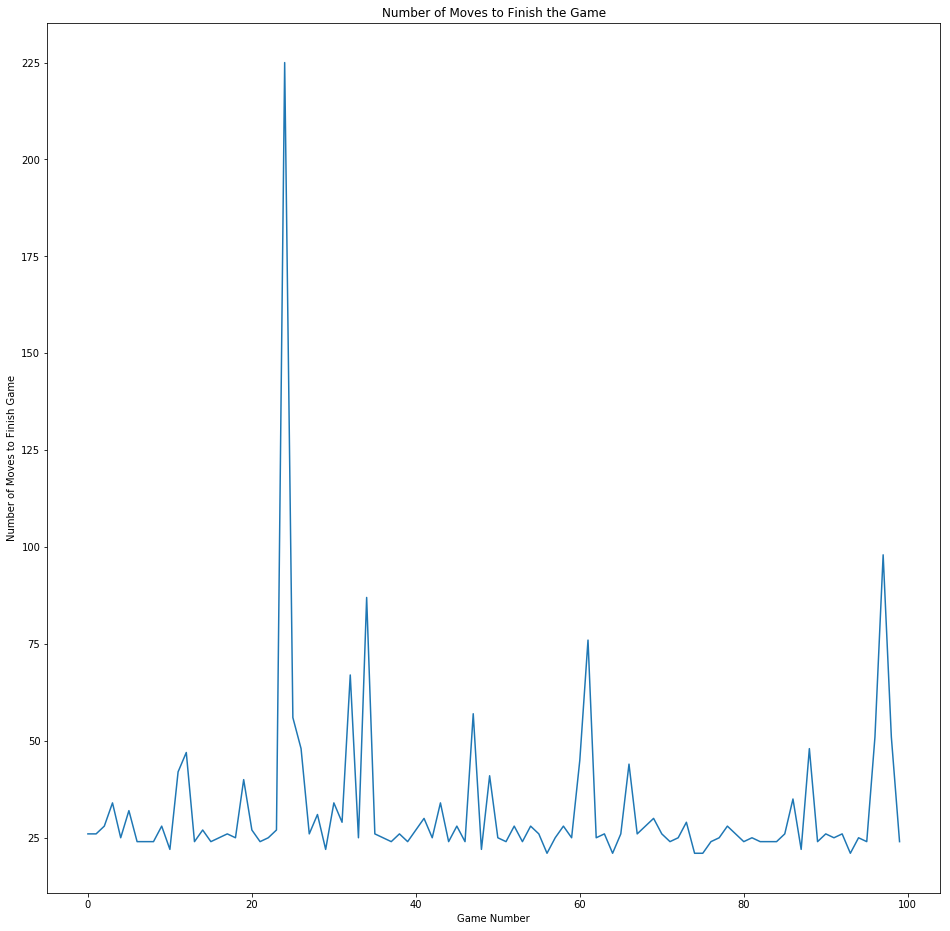

In [72]:
graph_game_results(gm_results)

## Conclusions

This project challenged me to understand machine learning at a level that the assignments were not able to.  I understood the assignments well, or when I didn't I could study the lectures and find help online.  

This project was different because I was trying to train a reinforcement learning model on my own game.  There were plenty of reinforcement learning tutorials available, but I had to translate them to my use case. When errors occurred my only option was to study the code instead of finding people online with the same problem.

There were two big errors that derailed my training for several days:  
* The first was that I initially did not normalize position. If a sheep was located at (100, 100) that was the value I was training the network with.  The issue with not normalizing data is that large values saturate the tanh activation function. Tanh reacts best to values in the range [-1, 1]. Outside of this range tanh reacts very slowly.  Because of this the network struggles to differentiate between saturated values like 40 and 100. The result is poor training performance.
* The second was a similar mistake, I failed to process categorical input so that it could be understood by the network.  I initially was inputting the action as a single integer 1-4 mapping to (up, right, down, left).  This has the same effect as not normalizing data. The four integers have disproportionate effect on the activation functions. I replaced the one integer system with the standard one-hot categorical encoding with four binary values.
Both of these errors were fundamental machine learning topics that had been covered in lectures.  That being said, I've now learned the topics and the reasons for them much better.  It's hard to forget errors that take days to debug.

Another takeaway was that learning how to use an unfamiliar tool in a project creates a number of added complications. This was my first time using Tensorflow. Tensorflow appears to be normal Python, but has some fundamental differences. The biggest difference is that a computational graph first has to be defined.  Then the graph is executed within the context of a Tensorflow session.  Which led to the following error:  
When defining the graph I had written  
```
train_op = optimizer.minimize((q_est - goal_q)**2)
```  
thinking it was short hand for  
```
loss = (q_est - goal_q)**2
train_op = optimizer.minimize(loss)
```
It turned out that the second example creates a 'loss' node in the graph that can be minimized by the optimizer.  The first example failed to create this node, so the optimizer had nothing to minimize. This elusive bug was occurring at the same time as the above problems compounding the difficulty of debugging.  In the future it would be better to isolate one unknown at a time when developing a machine learning system.

In [46]:
import io
from IPython.nbformat import current
import glob
nbfile = glob.glob('Law-Project.ipynb')
if len(nbfile) > 1:
    print('More than one ipynb file. Using the first one.  nbfile=', nbfile)
with io.open(nbfile[0], 'r', encoding='utf-8') as f:
    nb = current.read(f, 'json')
word_count = 0
for cell in nb.worksheets[0].cells:
    if cell.cell_type == "markdown":
        word_count += len(cell['source'].replace('#', '').lstrip().split(' '))
print('Word count for file', nbfile[0], 'is', word_count)

Word count for file Law-Project.ipynb is 1682


## References
* https://jacobbuckman.com/post/tensorflow-the-confusing-parts-1/
* https://medium.com/@awjuliani/super-simple-reinforcement-learning-tutorial-part-1